# Least-Square GAN

[Least-Square GAN](https://arxiv.org/abs/1611.04076) is proposed as an alternative to Vanila GAN to stablize the training. More importantly, when the discriminator learns too quickly, then the sigmoid cross entropy loss of Vanila GAN cannot allow the generator to learn from the samples drawn far away from the right side of the decision boundary. To overcome this problem, the authors of LSGAN paper presented a powerful yet simple idea of changing the loss function to discriminator and generator to a least square function as I will descibed later in this notebook. 

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


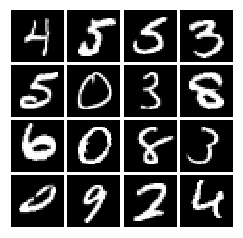

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)


## Discriminator
Our first step is to build a discriminator. We will use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [4]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        layer_1 = tf.layers.dense(x, 256, tf.nn.leaky_relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 256, tf.nn.leaky_relu, name="layer_2")
        logits = tf.layers.dense(layer_2, 1, name="logit")
        return logits

## Generator
Now to build a generator. We will again use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [5]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        layer_1 = tf.layers.dense(z, 1024, tf.nn.relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 1024, tf.nn.relu, name="layer_2")
        img = tf.layers.dense(layer_2, 784, tf.nn.tanh, name="image")
        return img

# Least Squares GAN

The generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [7]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss = 0.5 * (tf.reduce_mean((score_real - 1) ** 2) + tf.reduce_mean(score_fake ** 2))
    G_loss = 0.5 * tf.reduce_mean((score_fake - 1) ** 2)
    return D_loss, G_loss

# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if we set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!

In [10]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch_x})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train LSGAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

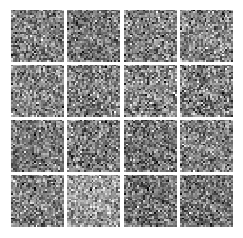


Iter: 0, D: 1.843, G:0.4131
Iter: 50, D: 0.0528, G:0.8359
Iter: 100, D: 0.1074, G:0.2501
Iter: 150, D: 0.0807, G:0.5769
Iter: 200, D: 0.1685, G:0.3469


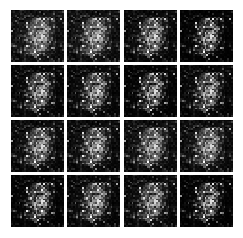


Iter: 250, D: 0.08752, G:0.3556
Iter: 300, D: 0.1126, G:0.543
Iter: 350, D: 0.09473, G:0.694
Iter: 400, D: 0.0571, G:0.603
Iter: 450, D: 0.08623, G:0.4318


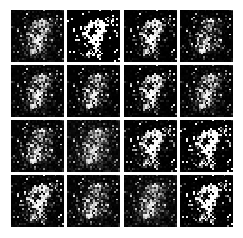


Iter: 500, D: 0.07251, G:0.4766
Iter: 550, D: 0.1197, G:0.4717
Iter: 600, D: 0.108, G:0.5096
Iter: 650, D: 0.1186, G:0.4127
Iter: 700, D: 0.07301, G:0.5459


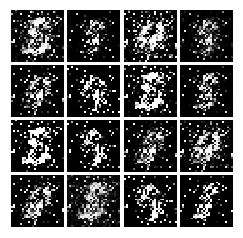


Iter: 750, D: 0.0694, G:0.4409
Iter: 800, D: 0.1189, G:0.3504
Iter: 850, D: 0.1288, G:0.2961
Iter: 900, D: 0.07389, G:0.3508
Iter: 950, D: 0.1041, G:0.2616


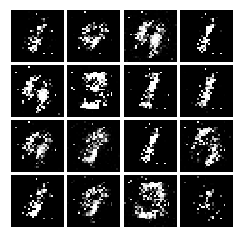


Iter: 1000, D: 0.1183, G:0.2689
Iter: 1050, D: 0.08018, G:0.3973
Iter: 1100, D: 0.09004, G:0.6154
Iter: 1150, D: 0.09792, G:0.3235
Iter: 1200, D: 0.1156, G:0.3041


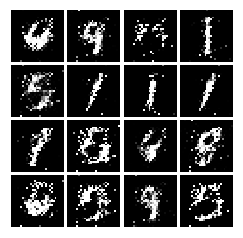


Iter: 1250, D: 0.1263, G:0.5165
Iter: 1300, D: 0.1055, G:0.3616
Iter: 1350, D: 0.1156, G:0.4096
Iter: 1400, D: 0.1207, G:0.5243
Iter: 1450, D: 0.1407, G:0.2936


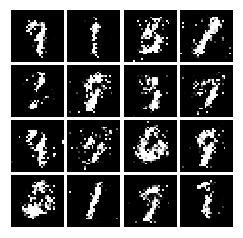


Iter: 1500, D: 0.1346, G:0.2778
Iter: 1550, D: 0.1304, G:0.3201
Iter: 1600, D: 0.1499, G:0.2524
Iter: 1650, D: 0.135, G:0.3303
Iter: 1700, D: 0.1786, G:0.2595


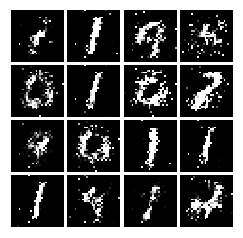


Iter: 1750, D: 0.1214, G:0.2095
Iter: 1800, D: 0.1489, G:0.2343
Iter: 1850, D: 0.154, G:0.2961
Iter: 1900, D: 0.1733, G:0.2227
Iter: 1950, D: 0.1578, G:0.2816


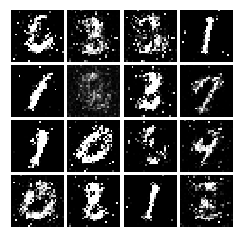


Iter: 2000, D: 0.1489, G:0.2944
Iter: 2050, D: 0.1974, G:0.2605
Iter: 2100, D: 0.195, G:0.2165
Iter: 2150, D: 0.1996, G:0.2375
Iter: 2200, D: 0.2261, G:0.1864


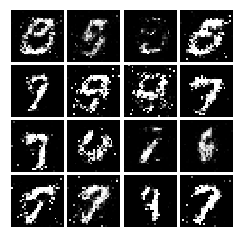


Iter: 2250, D: 0.1902, G:0.2093
Iter: 2300, D: 0.1801, G:0.2187
Iter: 2350, D: 0.1793, G:0.2792
Iter: 2400, D: 0.2466, G:0.1222
Iter: 2450, D: 0.1938, G:0.1925


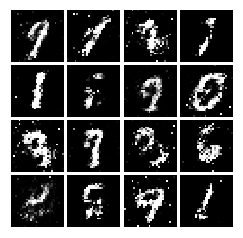


Iter: 2500, D: 0.1963, G:0.206
Iter: 2550, D: 0.1872, G:0.2479
Iter: 2600, D: 0.1891, G:0.269
Iter: 2650, D: 0.2007, G:0.2711
Iter: 2700, D: 0.2188, G:0.1283


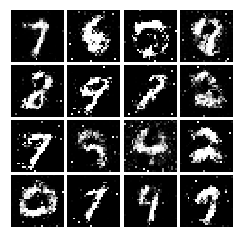


Iter: 2750, D: 0.2191, G:0.3222
Iter: 2800, D: 0.1963, G:0.2426
Iter: 2850, D: 0.2118, G:0.238
Iter: 2900, D: 0.1903, G:0.2573
Iter: 2950, D: 0.2373, G:0.123


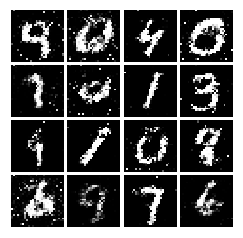


Iter: 3000, D: 0.1911, G:0.2115
Iter: 3050, D: 0.1959, G:0.1685
Iter: 3100, D: 0.2214, G:0.1366
Iter: 3150, D: 0.2145, G:0.1861
Iter: 3200, D: 0.2054, G:0.1945


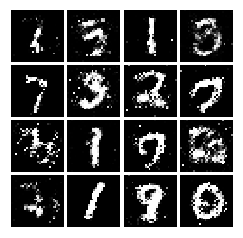


Iter: 3250, D: 0.1898, G:0.1998
Iter: 3300, D: 0.1967, G:0.1777
Iter: 3350, D: 0.2037, G:0.1936
Iter: 3400, D: 0.1924, G:0.2052
Iter: 3450, D: 0.2135, G:0.2201


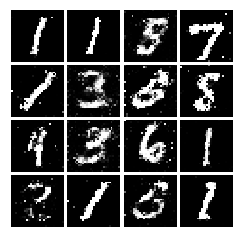


Iter: 3500, D: 0.2256, G:0.2336
Iter: 3550, D: 0.2108, G:0.1472
Iter: 3600, D: 0.2271, G:0.1036
Iter: 3650, D: 0.2103, G:0.2832
Iter: 3700, D: 0.2191, G:0.2123


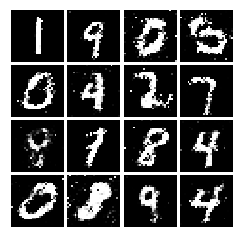


Iter: 3750, D: 0.2136, G:0.2214
Iter: 3800, D: 0.2063, G:0.189
Iter: 3850, D: 0.1972, G:0.2062
Iter: 3900, D: 0.2041, G:0.1544
Iter: 3950, D: 0.2199, G:0.2152


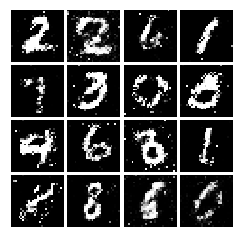


Iter: 4000, D: 0.2061, G:0.2268
Iter: 4050, D: 0.21, G:0.166
Iter: 4100, D: 0.2132, G:0.1142
Iter: 4150, D: 0.2055, G:0.1401
Iter: 4200, D: 0.2163, G:0.2112


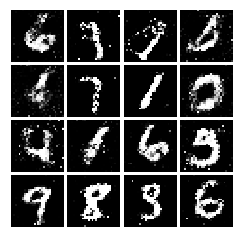


Iter: 4250, D: 0.233, G:0.1437
Final images


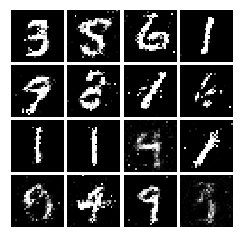

In [11]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Conclusion

I did not see any noticable difference for this simple experiment between Vanilla-GAN and LSGAN